# Install & import packages 

>If you do not have the librosa library you may install it with **pip install librosa**

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 13.3 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 189 kB 47.9 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 51 kB 303 kB/s 
Mounted at /content/gdrive


In [2]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from fastbook import *
import soundfile as sf


# Data Loading & Exploring Data Analysis

In [7]:
path = Path('/content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset')
path.ls()

(#4) [Path('/content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/orig_files'),Path('/content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/aug_files'),Path('/content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/all_files'),Path('/content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/images')]

#### 1. Normal Valves

In [8]:
f = path/'all_files/New_N_001.wav'
ipd.Audio(str(f))

#### 2. Aortic Stenosis

In [9]:
f = path/'all_files/New_AS_001.wav'
ipd.Audio(str(f))

#### 3. Mitral Stenosis

In [ ]:
f = path/'all_files/New_MS_001.wav'
ipd.Audio(str(f))

#### 4. Mitral Regurgitation

In [ ]:
f = path/'all_files/New_MR_001.wav'
ipd.Audio(str(f))

#### 5. Mitral Valve Prolapse

In [ ]:
f = path/'all_files/New_MVP_001.wav'
ipd.Audio(str(f))

# Building Utility Functions

In [ ]:
'''
Function for applying following transforms on the wave files:
1. Noise Addition using normal distribution of mean =0 and std =1
2. Shifting Sound wave
3. Time-stretching
4. Pitch - shifting of a wave
'''

def audio_data_transforms(wav_file_path:str, tfms_folder_path:str) -> None:
  fname = str(wav_file_path).split('/')[-1].split('.')[0]
  wav, sr = librosa.load(wav_file_path,sr=None)

  #tfms 1: Noise addition:
  wav_n = wav + 0.009*np.random.normal(0,1,len(wav))

  #tfms 2: Shifting Sound wave:
  wav_roll = np.roll(wav,int(sr/10))

  #tfms 3: Time - stretching
  factor = 0.4
  wav_time_stch = librosa.effects.time_stretch(wav,factor)

  #tfms 4: Pitch - Shifting
  wav_pitch_sf = librosa.effects.pitch_shift(wav,sr,n_steps=-5)

  wav_tfms = [wav_n,wav_roll,wav_time_stch,wav_pitch_sf]

  sf.write(f'{tfms_folder_path}/{fname}_noise.wav', wav_n, sr)
  sf.write(f'{tfms_folder_path}/{fname}_sshifting.wav', wav_roll, sr)
  sf.write(f'{tfms_folder_path}/{fname}_stretch.wav', wav_time_stch, sr)
  sf.write(f'{tfms_folder_path}/{fname}_pshift.wav', wav_pitch_sf, sr)


In [ ]:
'''
Function for converting all the waves files to image files.
'''

def generate_images_from_files(audio_path:str, spec_path:str):
  
  for file_path in progress_bar(audio_path.ls()):
    fname = str(file_path).split('/')[-1].split('.')[0]

    samples, sample_rate = librosa.load(file_path,sr=None)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_axis_off()
    ax.specgram(samples,Fs=2);
    fig.savefig(spec_path/f'{fname}.png',bbox_inches="tight",pad_inches=0)
    plt.close(fig)
    del sample_rate, samples, fig, ax

# Data Augmentation

>We will create more audio files through data augmentation and save them into **aug_files** folder

In [10]:
path/'orig_files'

Path('/content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/orig_files')

In [11]:
len((path/'orig_files').ls())

1000

In [ ]:
for f in progress_bar((path/'orig_files').ls()): audio_data_transforms(f,path/'aug_files')

In [ ]:
len((path/'aug_files').ls())

4000

Merging files

In [ ]:
!cp -a {path}/orig_files/. {path}/all_files
!cp -a {path}/aug_files/. {path}/all_files

In [12]:
assert len((path/'all_files').ls()) == 5000

In [ ]:
generate_images_from_files(path/'all_files', path/'images')

NameError: ignored

In [13]:
len((path/'images').ls())

5000

# Building the dataset


In [14]:
img_path = Path('/content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/images')

#Data Frame containing of file names with label so as to form structred folder
label_list = [str(f_path).split('/')[-1].replace('New_','').split('_')[0] for f_path in img_path.ls()]
fnames = [str(f_path).split('/')[-1] for f_path in img_path.ls()]
# fnames = [str(f_path) for f_path in img_path.ls()]
df = pd.DataFrame({'fnames':fnames, 'labels':label_list})
df.head()

,fnames,labels
0,New_MVP_007_pshift.png,MVP
1,New_N_099.png,N
2,New_AS_138.png,AS
3,New_N_008_pshift.png,N
4,New_MS_143.png,MS


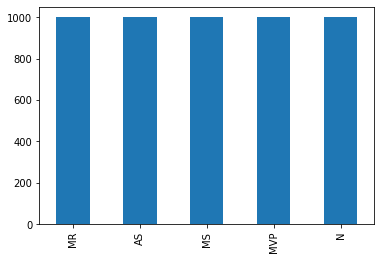

In [15]:
df['labels'].value_counts().plot.bar();

In [16]:
dblock = DataBlock(blocks= (ImageBlock,CategoryBlock),
                   get_items=get_image_files,
                   get_x = lambda x: x,
                   get_y = lambda x: str(x).split('/')[-1].replace('New_','').split('_')[0],
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(224)
                  )

In [17]:
dls = dblock.datasets(img_path)
dls[0]
dls.vocab

['AS', 'MR', 'MS', 'MVP', 'N']

In [18]:
dblock.summary(img_path)

Setting-up type transforms pipelines
Found 5000 items
2 datasets of sizes 4000,1000
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      /content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/images/New_MVP_035_pshift.png
    applying <lambda> gives
      /content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/images/New_MVP_035_pshift.png
    applying PILBase.create gives
      PILImage mode=RGB size=279x271
  Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/gdrive/MyDrive/ML/heart-murmurs-ai/dataset/images/New_MVP_035_pshift.png
    applying <lambda> gives
      MVP
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=279x271, TensorCategory(3))


Found 5000 items
2 

In [19]:
dls=dblock.dataloaders(img_path, bs=64)

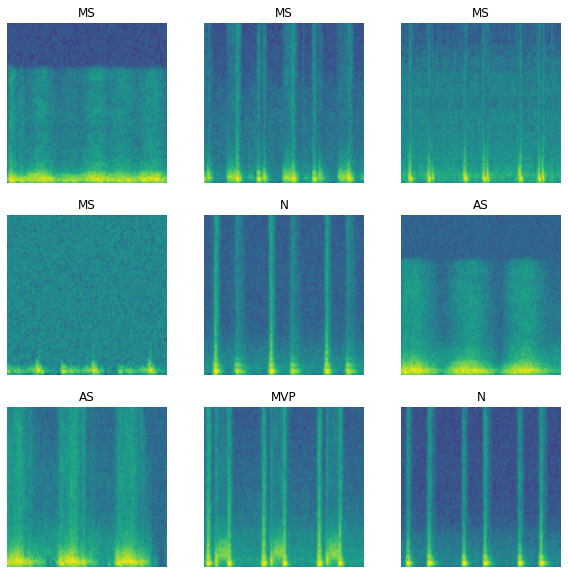

In [20]:
dls.show_batch(figsize=(10,10))

# Training Model

In [21]:
learn = cnn_learner(dls, models.resnet34, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0012022644514217973)

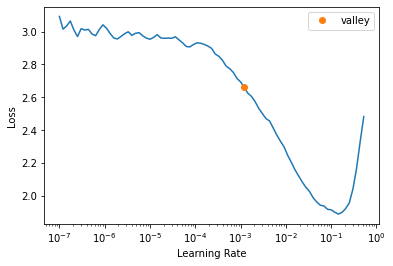

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(15,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.127924,0.420587,0.863000,01:07
1,0.540269,0.273542,0.912000,01:06
2,0.306433,0.497112,0.877000,01:08
3,0.228644,0.426600,0.883000,01:06
4,0.192272,0.132305,0.969000,01:06
5,0.139241,0.089709,0.973000,01:06
6,0.110352,0.075140,0.978000,01:06
7,0.089308,0.043552,0.988000,01:08
8,0.055394,0.023526,0.995000,01:06
9,0.034173,0.016158,0.995000,01:06


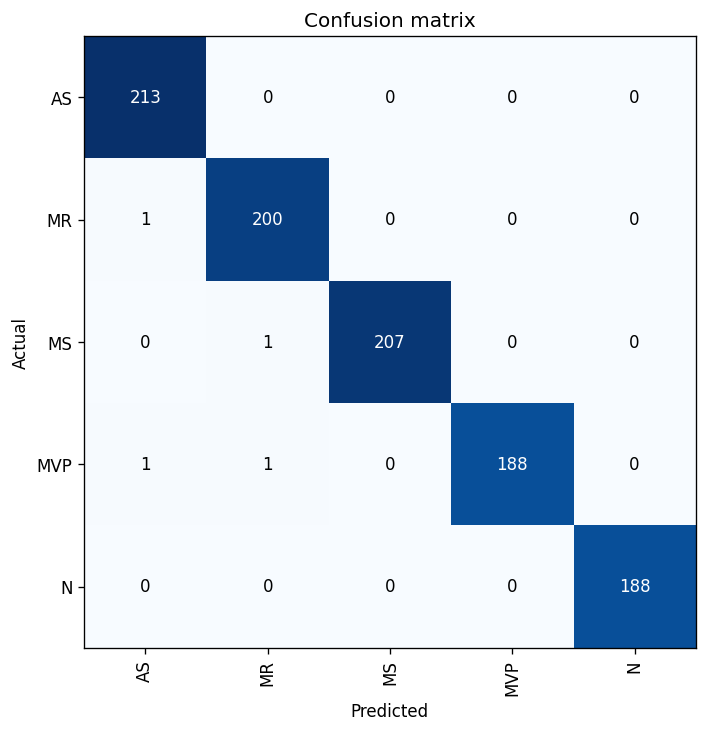

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=120)